In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

In [3]:

def extract_deep_features(file_path, duration=3, sr=22050, max_len=130):
    try:
        y, sr = librosa.load(file_path, sr=sr)
        desired_length = duration * sr
        if len(y) < desired_length:
            y = np.pad(y, (0, desired_length - len(y)))
        else:
            y = y[:desired_length]

        # Base features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)              # (40, T)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        rms = librosa.feature.rms(y=y)

        # Stack all features along axis=0
        all_feat = np.vstack([
            mfcc, delta, delta2, chroma, mel, contrast, tonnetz, zcr, rms
        ])  # shape: (n_features, T)

        # Transpose to (T, features)
        all_feat = all_feat.T  # shape: (T, n_features)

        # Pad/truncate time axis to fixed length
        if all_feat.shape[0] < max_len:
            pad_width = max_len - all_feat.shape[0]
            all_feat = np.pad(all_feat, ((0, pad_width), (0, 0)), mode='constant')
        else:
            all_feat = all_feat[:max_len, :]

        return all_feat

    except Exception as e:
        print(f"❌ Error in {file_path}: {e}")
        return None

In [4]:
from tqdm import tqdm

data_path = '/content/drive/MyDrive/Audio_dataset'

parent_folders = ['Audio_Speech_Actors_01-24', 'Audio_Song_Actors_01-24']

# Emotion code map (adjust if needed)
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def get_emotion_from_filename(filename):
    try:
        code = filename.split("-")[2]  # example: '03' for happy
        return emotion_map.get(code)
    except:
        return None

X, y = [], []
modality_list = []  # Track speech/song
emotion_list = []   # Track emotion for stratified split

for parent in parent_folders:
    modality = 'speech' if 'Speech' in parent else 'song'
    parent_path = os.path.join(data_path, parent)

    for actor_folder in tqdm(os.listdir(parent_path)):
        actor_path = os.path.join(parent_path, actor_folder)

        for file in os.listdir(actor_path):
            file_path = os.path.join(actor_path, file)
            emotion = get_emotion_from_filename(file)

            if emotion is None:
                continue

            features = extract_deep_features(file_path)
            if features is not None:
                X.append(features)
                y.append(emotion)
                emotion_list.append(emotion)
                modality_list.append(modality)

X = np.array(X)
y = np.array(y)
print("✅ Done. Deep features shape:", X.shape, "Labels:", len(y))

100%|██████████| 24/24 [13:27<00:00, 33.64s/it]


✅ Done. Deep features shape: (2452, 130, 187) Labels: 2452


In [8]:
np.unique(modality_list)

array(['song', 'speech'], dtype='<U6')

In [9]:
# Label encoding and train/test split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

stratify_labels = [f"{e}_{m}" for e, m in zip(emotion_list, modality_list)]

# Encode emotion labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert to arrays
X = np.array(X)
y_encoded = np.array(y_encoded)
stratify_labels = np.array(stratify_labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=stratify_labels, random_state=42
)

In [10]:
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf

def build_regularized_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # 🔹 CNN Block with Dropout + L2 regularization
    x = layers.Conv1D(
        128, 5, padding='same', activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.MaxPooling1D(2)(x)

    # 🔹 BiLSTM with Dropout
    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
    )(x)

    # 🔹 Attention Mechanism
    attention = layers.Dense(1, activation='tanh')(x)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(128)(attention)
    attention = layers.Permute([2, 1])(attention)
    x = layers.multiply([x, attention])

    # ⚠️ FIX: Add output_shape to Lambda
    x = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1), output_shape=(128,))(x)

    # 🔹 Dense layers with regularization
    x = layers.Dense(
        64, activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    )(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


In [17]:
from tensorflow.keras import layers
model = build_regularized_model(
    input_shape=X_train.shape[1:],
    num_classes=len(label_encoder.classes_)
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 🛑 EarlyStopping to stop overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=15,
    restore_best_weights=True,
    monitor='val_accuracy'
)

history = model.fit(
    X_train, y_train,
    validation_data = [X_test,y_test],
    epochs=80,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 246ms/step - accuracy: 0.2120 - loss: 2.1935 - val_accuracy: 0.1772 - val_loss: 2.7428
Epoch 2/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.4025 - loss: 1.7980 - val_accuracy: 0.2668 - val_loss: 2.5997
Epoch 3/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.4836 - loss: 1.5089 - val_accuracy: 0.3971 - val_loss: 1.9470
Epoch 4/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.5702 - loss: 1.3372 - val_accuracy: 0.5764 - val_loss: 1.3784
Epoch 5/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.6049 - loss: 1.2157 - val_accuracy: 0.5153 - val_loss: 1.5093
Epoch 6/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.6272 - loss: 1.1669 - val_accuracy: 0.5132 - val_loss: 1.5174
Epoch 7/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.6362 - loss: 1.1334 - val_accuracy: 0.5458 - val_loss: 1.4389
Epoch 8/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.7010 - loss: 1.0266 - val_accu

In [18]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step


In [19]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")


              precision    recall  f1-score   support

       angry       1.00      0.79      0.88        75
        calm       0.89      0.91      0.90        75
     disgust       0.81      0.89      0.85        38
     fearful       0.68      0.82      0.74        76
       happy       0.83      0.88      0.85        76
     neutral       0.85      0.92      0.88        37
         sad       0.81      0.59      0.68        75
   surprised       0.73      0.90      0.80        39

    accuracy                           0.82       491
   macro avg       0.83      0.84      0.82       491
weighted avg       0.83      0.82      0.82       491

✅ Test Accuracy: 0.8208


In [20]:
f1 = f1_score(y_test, y_pred, average='macro')  # You can also try 'weighted'
print(f"✅ Macro F1 Score: {f1:.4f}")

✅ Macro F1 Score: 0.8246


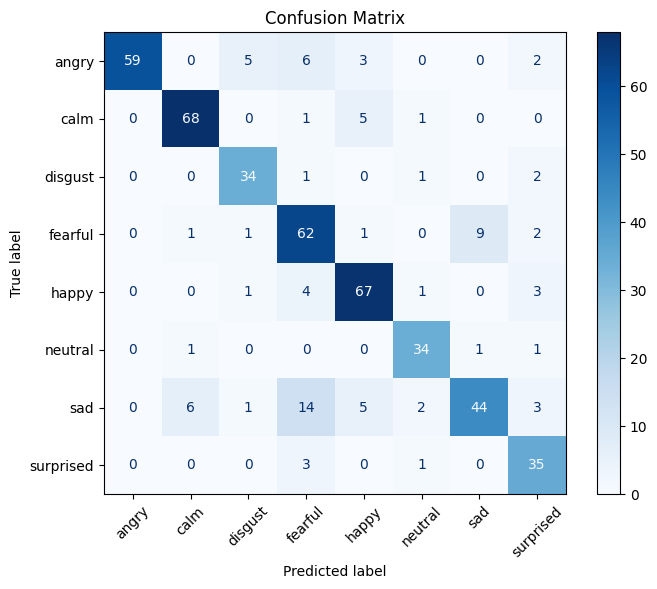

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

# Step 2: Create the display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Step 3: Plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()
